# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import csv
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_test.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# get dict for signnames
with open('./signnames.csv', mode='r') as infile:
    header = infile.readline()
    data = csv.reader(infile)
    signnames = {int(rows[0]):rows[1] for rows in data}
    



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

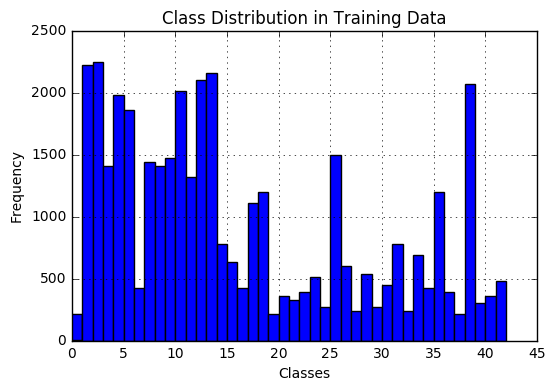

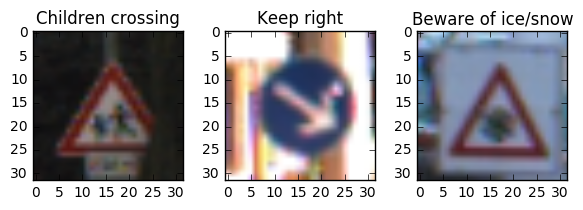

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# figure 1: class distribution in training data
def plot_classes(data, n_classes, title='Class Distribution in Training Data'):
    plt.figure(1)
    plt.hist(data, bins=range(n_classes))
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid()
    plt.show()


# plot random example of image with signname as title
def plot_random_images(feats, labels, n_train):
    num_subplots = 3
    fig = plt.figure(2)
    for i in range(1, num_subplots+1):
        index = random.randint(0, n_train)
        fig.add_subplot(1, num_subplots, i)
        plt.imshow(feats[index])
        plt.title(signnames[labels[index]])
    plt.tight_layout()
    plt.show()

plot_classes(y_train, n_classes)
plot_random_images(X_train, y_train, n_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
import cv2
import numpy as np
import tensorflow as tf


def normalize_and_center(img):
    # convert from RGB to YUV
    img_YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # eualize histogram in Y channel
    img_YUV[:,:,0] = cv2.equalizeHist(img_YUV[:,:,0])
    # convert back to RGB
    image = cv2.cvtColor(img_YUV, cv2.COLOR_YUV2RGB)
    # normalize and center
    return (image/255.0)-0.5

def convert_data(dataset):
    ret = np.zeros((dataset.shape[0], 32, 32, 3))
    for i in range(dataset.shape[0]): 
        ret[i] = normalize_and_center(dataset[i])
    return ret


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

- improved the contrast by equalizing the Y-channel (RGB -> YUV-Colorspace, cv2.equalizeHist on Y-channel, convert back to RGB)
- normalized every image by dividing its channels by 255 and shifting it b 0.5, so every image is centered around 0

- no color conversion, because the first convolutional layer will be used to 'choose' the optimum colorspace 

Preprocessing is done after image augmentation (see below), as the affine transformations used are a lot faster with integer-values! 

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
import random

#get additional data:
# rotate, shift, skew, change contrast

def shift_img(x_shift, y_shift):
    '''Calculate matrix to shift image by x_shift and y_shift pixels. Use matrix with cv2.warpAffine'''
    return np.float32([[1,0,x_shift],[0,1,y_shift]])

def rotate_img(img, deg):
    '''Calculate matrix to rotate image by deg degrees. Use matrix with cv2.warpAffine'''
    center = (img.shape[0]/2, img.shape[1]/2)
    return cv2.getRotationMatrix2D(center, deg, 1)

def shear_img(img, shear):
    '''Calculates a matrix to shear an image, based on a random variation of a given set of points, 
    with a maximum distance of 'shear from the original point, for every element of the new point. 
    Use matrix with cv2.warpAffine'''
    ori_pts = np.float32([[int(img.shape[0]*0.5) ,int(img.shape[1]*0.3) ],
                          [int(img.shape[0]*0.3) ,int(img.shape[1]*0.7) ],  
                          [int(img.shape[0]*0.7) ,int(img.shape[1]*0.3) ]])
    add = np.array(np.random.uniform(-1.0, 1.0, (3,2))*shear*1.0).astype(int)
    shear_matrix = cv2.getAffineTransform(ori_pts, np.add(ori_pts, add).astype('float32'))
    return shear_matrix  
    
def generate_images(img):
    '''Apply several affine transformations with random parameters as well as a contrast shift, to generate data'''
    # define parameters
    max_shear = 2
    max_rot = 25
    max_shift = 5
    max_cont_gain = 0.1
    max_cont_bias = 0.1
    # apply transformations   
    # get matrices for affine transformation
    m_shear = shear_img(img, np.random.uniform()*max_shear)
    m_rot = rotate_img(img, np.random.uniform(-1.0, 1.0)*max_rot)
    m_shift = shift_img(np.random.uniform(-1.0, 1.0)*max_shift, np.random.uniform(-1.0, 1.0)*max_shift)
    # combine matrices
    comb_matrix = combineTransformationMatrices(m_shear, m_rot, m_shift)
    #apply warpAffine
    out = cv2.warpAffine(img, comb_matrix, (32, 32))
    return out.reshape((1,32,32,3))

def combineTransformationMatrices(*args):
    # vstack [0, 0, 1] for matrix multiplication
    matrices = [np.vstack([args[i], np.array([0, 0, 1])]) for i in range(len(args))]
    ret = args[0]
    for idx in range(1, len(args)):
        ret = np.matmul(ret, matrices[idx])
    
    return ret[:2, :3]
    
def augment_data(featureset, labelset, iterations, verbose=False):
    if verbose:
        print('Augmenting {0!s} images with {1!s} additional images...'.format(featureset.shape[0], iterations))
    img_indices = range(featureset.shape[0])
    for img_idx in img_indices:
        if verbose and img_idx % 500 ==0:
            print('Processing number: ', img_idx)
        for iters in range(iterations):
            featureset=np.vstack([featureset, generate_images(featureset[img_idx])])
            labelset=np.hstack([labelset, labelset[img_idx]])
    if verbose:
        print('.. Done!')
    return featureset, labelset



Augmenting 2 images with 3 additional images...
Processing number:  0
.. Done!


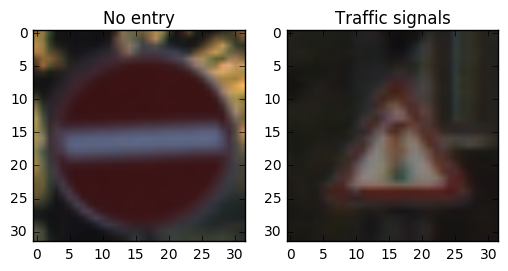

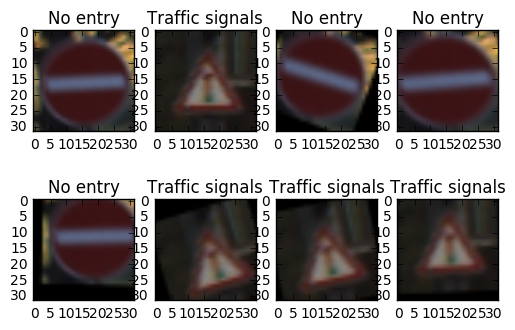

In [6]:
# test augment data
from sklearn.utils import shuffle
add_images = 3
num_feats = 2
X, y = shuffle(X_train, y_train)

feats = X[0:num_feats]
labels = y[0:num_feats]

X_aug, y_aug = augment_data(feats, labels, add_images, verbose=True)

fig = plt.figure(1)
for i in range(num_feats):
    fig.add_subplot(1,num_feats, i+1)
    plt.imshow(feats[i].reshape((32,32,3)))
    plt.title(signnames[labels[i]])

fig = plt.figure(2)    
for i in range((add_images+1)*num_feats):
    fig.add_subplot(num_feats, add_images+1, i+1)
    plt.imshow(X_aug[i].reshape((32,32,3)))
    plt.title(signnames[y_aug[i]])

In [7]:
import os.path
import pickle
#check for existing file of preprocessed data
training_file = './traffic-signs-data/AugmentedData.p'
if os.path.isfile(training_file): 
    print('Loading data from {!s}....'.format(training_file), end='')
    with open(training_file, mode='rb') as f:
        data = pickle.load(f)
    
    X_train, y_train = data['X_train'], data['y_train']
    X_validation, y_validation = data['X_validation'], data['y_validation']
    print('... Done!')

    
else:   # if no file is found, augment and store data
    print('No augmented data found! Augmenting dataset now:')
    # split X_train in training and validation sets
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    # augment training data
    X_train, y_train = augment_data(X_train, y_train, 5, verbose=True)
    # save data 
    data = {'X_train':X_train, 'y_train':y_train, 'X_validation':X_validation, 'y_validation':y_validation, 
            'X_test':X_test, 'y_test':y_test}
    # save as pickle
    with open(training_file, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


Loading data from ./traffic-signs-data/AugmentedData.p....... Done!


In [8]:
# Preprocess (equalize, normalize and center) all data
if len(X_train) == n_train:
    from sklearn.model_selection import train_test_split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train = convert_data(X_train)
X_validation = convert_data(X_validation)
X_test = convert_data(X_test)

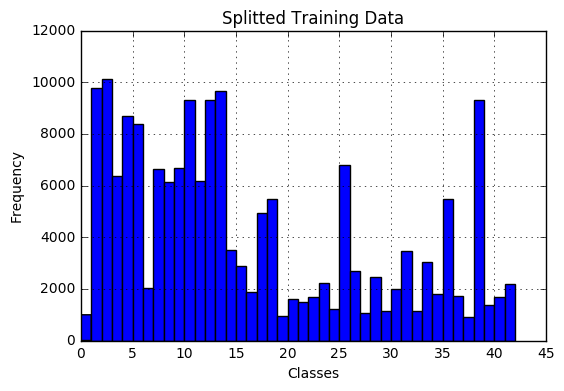

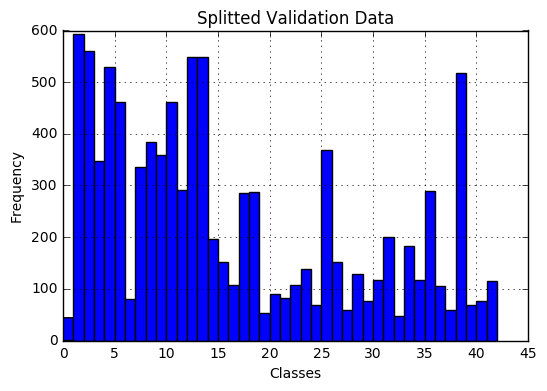

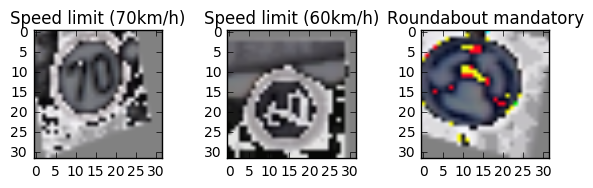

In [9]:
# plot classes of training and validation data
plot_classes(y_train, n_classes, 'Splitted Training Data')
plot_classes(y_validation, n_classes, 'Splitted Validation Data')

#plot_random_images of training data after preprocessing
plot_random_images(X_train, y_train, len(X_train))

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


EPOCHS = 50
BATCH_SIZE = 256

# Helperfunctions
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1, padding='VALID'):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, size=2, step=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, size, size, 1],
        strides=[1, step, step, 1],
        padding='VALID')


In [11]:
# net architecture
def BottleneckNet(x, keep_prob): 
    
    
    # Hyperparameters
    mu = 0
    sigma = 0.05
    
    layer_depth = {
    'layer_0': 3,
    'layer_1': 6,
    'down_2': 3,
    'layer_2': 8,
    'up_2': 16,
    'down_3': 8,
    'layer_3': 16,
    'up_3': 32,
    'down_4': 16,
    'layer_4': 32,
    'up_4': 64,
    'fully_connected_1': 1024,
    'fully_connected_2': 256
    }
    
    # (height, width, input_depth, output_depth)
    weights = {
    'layer_0': tf.Variable(tf.truncated_normal(
        [1, 1, 3, layer_depth['layer_0']], mean = mu, stddev = sigma)),
    'layer_1': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['layer_0'], layer_depth['layer_1']], mean = mu, stddev = sigma)),
    'down_2': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['layer_1'], layer_depth['down_2']], mean = mu, stddev = sigma)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['down_2'], layer_depth['layer_2']], mean = mu, stddev = sigma)),
    'up_2': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['layer_2'], layer_depth['up_2']], mean = mu, stddev = sigma)),
    'down_3': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['up_2'], layer_depth['down_3']], mean = mu, stddev = sigma)),
    'layer_3': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['down_3'], layer_depth['layer_3']], mean = mu, stddev = sigma)),
    'up_3': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['layer_3'], layer_depth['up_3']], mean = mu, stddev = sigma)),
    'down_4': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['up_3'], layer_depth['down_4']], mean = mu, stddev = sigma)),
    'layer_4': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['down_4'], layer_depth['layer_4']], mean = mu, stddev = sigma)),
    'up_4': tf.Variable(tf.truncated_normal(
        [1, 1, layer_depth['layer_4'], layer_depth['up_4']], mean = mu, stddev = sigma)),
    'fully_connected_1': tf.Variable(tf.truncated_normal(
        [4736, layer_depth['fully_connected_1']], mean = mu, stddev = sigma)),
    'fully_connected_2': tf.Variable(tf.truncated_normal(
        [layer_depth['fully_connected_1'], layer_depth['fully_connected_2']], mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_depth['fully_connected_2'], n_classes], mean = mu, stddev = sigma))
         }
         
    biases = {
    'layer_0': tf.Variable(tf.zeros(layer_depth['layer_0'])),  
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'down_2': tf.Variable(tf.zeros(layer_depth['down_2'])),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'up_2': tf.Variable(tf.zeros(layer_depth['up_2'])),    
    'down_3': tf.Variable(tf.zeros(layer_depth['down_3'])),
    'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3'])),
    'up_3': tf.Variable(tf.zeros(layer_depth['up_3'])),    
    'down_4': tf.Variable(tf.zeros(layer_depth['down_4'])),
    'layer_4': tf.Variable(tf.zeros(layer_depth['layer_4'])),
    'up_4': tf.Variable(tf.zeros(layer_depth['up_4'])),    
    'fully_connected_1': tf.Variable(tf.zeros(layer_depth['fully_connected_1'])),
    'fully_connected_2': tf.Variable(tf.zeros(layer_depth['fully_connected_2'])),
    'out': tf.Variable(tf.zeros(n_classes))
    }
    
    
    #Layer 0: Convolutional. Input = 32x32x3. Output = 32x32x3.
    conv0 = conv2d(x, weights['layer_0'], biases['layer_0'])
    
    #Layer 1: Convolutional.Input = 32x32x3 Output = 30x30x6.
    #Using Bottleneck Structure: 
    # 3x3 conv
    conv1 = conv2d(conv0, weights['layer_1'], biases['layer_1'])  
    
    #Layer 2: Convolutional.Input = 30x30x6 Output = 28x28x16.
    #Using Bottleneck Structure: 1x1 conv -> 3x3 conv - 1x1 conv        
    #1x1 conv to increase depth
    down2 = conv2d(conv1, weights['down_2'], biases['down_2'])
    # 3x3 conv
    conv2 = conv2d(down2, weights['layer_2'], biases['layer_2'])
    conv2 = tf.nn.dropout(conv2, keep_prob)    
    #1x1 conv to increase depth
    up2 = conv2d(conv2, weights['up_2'], biases['up_2'])
    
    #Pooling. Input = 28x28x16. Output = 14x14x16.
    pool2 = maxpool2d(up2, size=2, step=2)
    
    #Layer 3: Convolutional.Input = 14x14x16 Output = 12x12x32.
    #Using Bottleneck Structure: 1x1 conv -> 3x3 conv - 1x1 conv
    #1x1 conv to increase depth
    down3 = conv2d(pool2, weights['down_3'], biases['down_3'])
    # 3x3 conv
    conv3 = conv2d(down3, weights['layer_3'], biases['layer_3'])    
    #1x1 conv to increase depth
    up3 = conv2d(conv3, weights['up_3'], biases['up_3'])
    
    #Layer 4: Convolutional.Input = 12x12x32 Output = 10x10x64.
    #Using Bottleneck Structure: 1x1 conv -> 3x3 conv - 1x1 conv
    #1x1 conv to increase depth
    down4 = conv2d(up3, weights['down_4'], biases['down_4'])
    # 3x3 conv
    conv4 = conv2d(down4, weights['layer_4'], biases['layer_4'])
    conv4 = tf.nn.dropout(conv4, keep_prob)    
    #1x1 conv to increase depth
    up4 = conv2d(conv4, weights['up_4'], biases['up_4'])
    #Pooling. Input = 10x10x64. Output = 5x5x64.
    pool4 = maxpool2d(up4, size=2, step=2)
      
    #Flatten.
    #Input 1 = 5x5x64. Output = 1600.
    #Input 2 = 14x14x16. Output = 3136.
    #Layer 3: Fully Connected. Input = 4736. Output = 1024.
    #Activation.
    fc1_1 = flatten(pool4)
    fc1_2 = flatten(pool2)
    fc1 = tf.concat(1, [fc1_1, fc1_2])
    fc1 = tf.add( tf.matmul(fc1, weights['fully_connected_1']), biases['fully_connected_1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    #Layer 4: Fully Connected. Input = 512. Output = 256.
    #Activation.
    fc2 = tf.add( tf.matmul(fc1, weights['fully_connected_2']), biases['fully_connected_2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    #Layer 5: Fully Connected. Input = 256. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [12]:
### Train your model here.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)
    
#Training Pipeline
rate = 0.0001

logits = BottleneckNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    loss = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        _, accuracy, batch_loss = sess.run([training_operation, accuracy_operation, loss_operation], 
                                           feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        loss.append(batch_loss)
    return total_accuracy / num_examples, np.mean(loss)

In [13]:
training_loss = []
train_accuracy = []
valid_accuracy = []
valid_loss=[]

# Train Model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        training_accuracy = 0
        batch_loss = []
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, accuracy, loss = sess.run([training_operation, accuracy_operation, loss_operation], 
                                         feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
            batch_loss.append(loss)
            training_accuracy += (accuracy * len(batch_x))      
        training_loss.append(np.mean(batch_loss))
        train_accuracy.append(training_accuracy/len(X_train))
        val_acc, val_loss = evaluate(X_validation, y_validation)
        valid_accuracy.append(val_acc)
        valid_loss.append(val_loss)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy[-1]))
        print("Validation Accuracy = {:.3f}".format(valid_accuracy[-1]))
        print()
        
    # test data?
    X_test, y_test = shuffle(X_test, y_test)
    
    accuracy, _ = evaluate(X_test, y_test)
    print("Test Accuracy: {:.3f}".format(accuracy))
    
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'BottleneckNet.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.055
Validation Accuracy = 0.054

EPOCH 2 ...
Training Accuracy = 0.055
Validation Accuracy = 0.061

EPOCH 3 ...
Training Accuracy = 0.055
Validation Accuracy = 0.055

EPOCH 4 ...
Training Accuracy = 0.055
Validation Accuracy = 0.058

EPOCH 5 ...
Training Accuracy = 0.055
Validation Accuracy = 0.055

EPOCH 6 ...
Training Accuracy = 0.055
Validation Accuracy = 0.056

EPOCH 7 ...
Training Accuracy = 0.055
Validation Accuracy = 0.061



KeyboardInterrupt: 

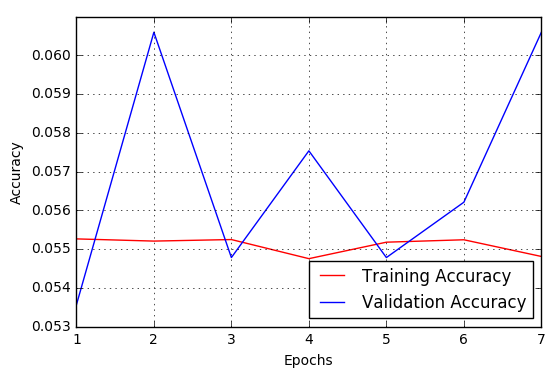

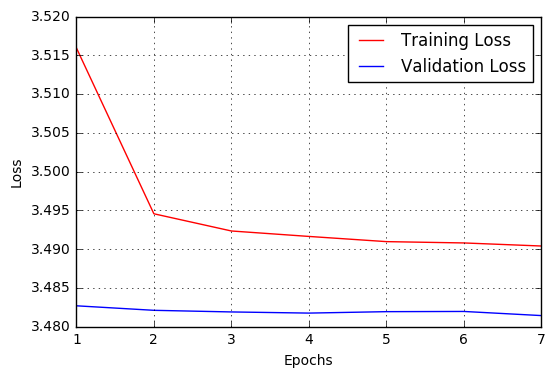

In [14]:
# plot Accuracy
plt.figure()
x_vals=range(1, len(train_accuracy)+1)
plt.plot(x_vals, train_accuracy, '-r', label='Training Accuracy')
plt.plot(x_vals, valid_accuracy, '-b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
# plot loss
plt.figure()
plt.plot(x_vals, training_loss, '-r', label='Training Loss')
plt.plot(x_vals, valid_loss, '-b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [15]:
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, 'BottleneckNet.ckpt')

    # test data?
    X_test, y_test = shuffle(X_test, y_test)
    
    accuracy, _ = evaluate(X_test, y_test)
    print("Test Accuracy: {:.3f}".format(accuracy))

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for BottleneckNet.ckpt
	 [[Node: save/RestoreV2_79 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_79/tensor_names, save/RestoreV2_79/shape_and_slices)]]
	 [[Node: save/RestoreV2_19/_55 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_146_save/RestoreV2_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_79', defined at:
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-dbdf5258ae6f>", line 1, in <module>
    saver = tf.train.Saver()
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/benni/anaconda2/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for BottleneckNet.ckpt
	 [[Node: save/RestoreV2_79 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_79/tensor_names, save/RestoreV2_79/shape_and_slices)]]
	 [[Node: save/RestoreV2_19/_55 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_146_save/RestoreV2_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.